# PIOMAS Reanlysis

- Loads in all daily forecasts of sea ice extent
- Regrids to polar stereographic,
- Saves to netcdf files grouped by year

In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

# Standard Imports
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ESIO Imports

from esio import EsioData as ed
from esio import import_data

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
E = ed.EsioData.load()
# Directories
model='piomas'
runType='reanalysis'
data_dir = E.model[model][runType]['native']
data_out = E.model[model][runType]['sipn_nc']
model_grid_file = E.model[model]['grid']
stero_grid_file = E.obs['NSIDC_0051']['grid']

In [4]:
model_grid = import_data.load_grid_info(model_grid_file, model=model)

In [5]:
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [6]:
# Regridding Options
method='conservative' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

In [7]:
weights_flag = False # Flag to set up weights have been created

cvar = 'sic'

# for year in np.arange(1979, 1980, 1):
for year in np.arange(1979, 2019, 1):

    # Read in Daily Files
    c_f = os.path.join(data_dir, 'area', 'aiday.H'+str(year))

    X = import_data.read_piomas_scalar_daily(c_f, varname=cvar)
    X.coords['nj'] = model_grid.nj
    X.coords['ni'] = model_grid.ni
    X.coords['lat'] = model_grid.lat
    X.coords['lon'] = model_grid.lon
    X.coords['lat_b'] = model_grid.lat_b
    X.coords['lon_b'] = model_grid.lon_b
    X.coords['imask'] = model_grid.imask
    
    # Set sic below 0 to 0
    if X.sic.min().values < 0:
        print("Some negative SIC "+str(X.sic.min().values)+" found in input PIOMAS, setting to 0")
        X = X.where(X>=0, other=0)
        
    # Apply model mask
    X = X.where(X.imask)
    
    # Calculate regridding matrix
    regridder = xe.Regridder(X, obs_grid, method, periodic=True, reuse_weights=weights_flag)
    weights_flag = True # Set true for following loops
    
    # Add NaNs to empty rows of matrix (forces any target cell with ANY source cells containing NaN to be NaN)
    regridder = import_data.add_matrix_NaNs(regridder)
    
    # Regrid variable
    var_out = regridder(X[cvar])

    # # Save regridded to netcdf file
    f_out = os.path.join(data_out, model+'_'+str(year)+'_Stereo.nc')
    var_out.to_netcdf(f_out)
#     var_out = None # Memory clean up
    print('Saved ', f_out)

Some negative SIC -0.0009711980819702148 found in input PIOMAS, setting to 0
Create weight file: conservative_120x360_304x448.nc


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Saved  /home/disk/sipn/nicway/data/model/piomas/reanalysis/sipn_nc/piomas_1979_Stereo.nc
Some negative SIC -0.000994563102722168 found in input PIOMAS, setting to 0
Reuse existing file: conservative_120x360_304x448.nc
Saved  /home/disk/sipn/nicway/data/model/piomas/reanalysis/sipn_nc/piomas_1980_Stereo.nc
Some negative SIC -0.0009998083114624023 found in input PIOMAS, setting to 0
Reuse existing file: conservative_120x360_304x448.nc
Saved  /home/disk/sipn/nicway/data/model/piomas/reanalysis/sipn_nc/piomas_1981_Stereo.nc
Some negative SIC -0.0009485483169555664 found in input PIOMAS, setting to 0
Reuse existing file: conservative_120x360_304x448.nc
Saved  /home/disk/sipn/nicway/data/model/piomas/reanalysis/sipn_nc/piomas_1982_Stereo.nc
Some negative SIC -0.0009837150573730469 found in input PIOMAS, setting to 0
Reuse existing file: conservative_120x360_304x448.nc
Saved  /home/disk/sipn/nicway/data/model/piomas/reanalysis/sipn_nc/piomas_1983_Stereo.nc
Some negative SIC -0.000957727432250

In [8]:
# Clean up
regridder.clean_weight_file()  # clean-up

Remove file conservative_120x360_304x448.nc


# Plotting

In [9]:
sic_all = xr.open_dataset(f_out).sic

In [10]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'red')

Text(0.5,1,'Target Grid')

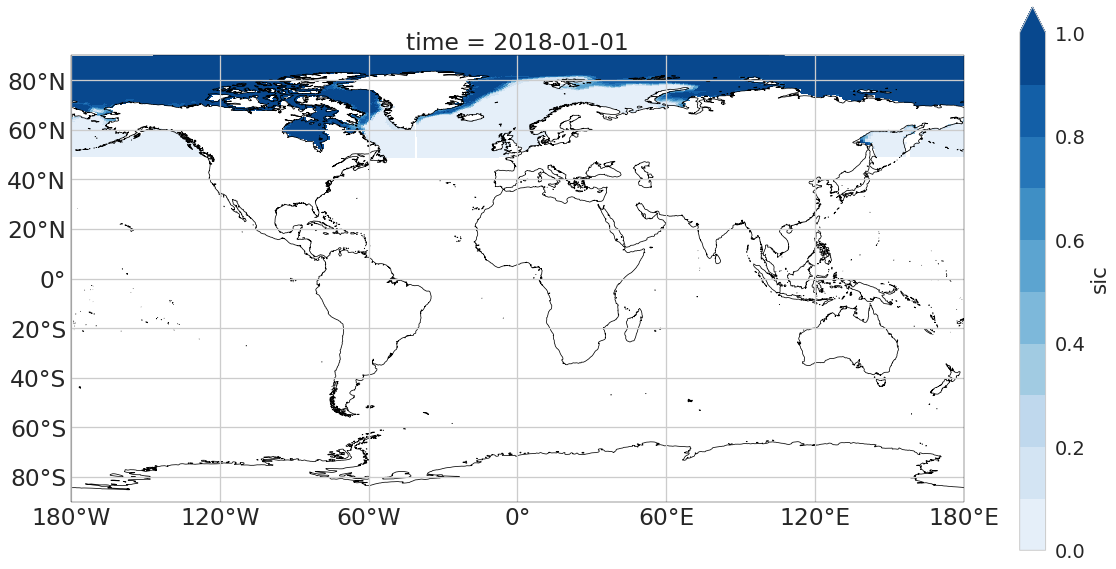

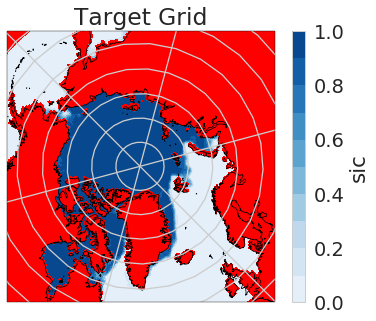

In [11]:
# Plot original projection
plt.figure(figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
ds_p = X.sic.isel(time=0)
ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                 vmin=0, vmax=1,
                                 cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)),
                    transform=ccrs.PlateCarree());
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

# Plot SIC on target projection
(f, ax1) = ice_plot.polar_axis()
ds_p2 = sic_all.isel(time=0)
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
ax1.set_title('Target Grid')
